## Loading the dataset and exploratory data analysis

In [23]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pickle

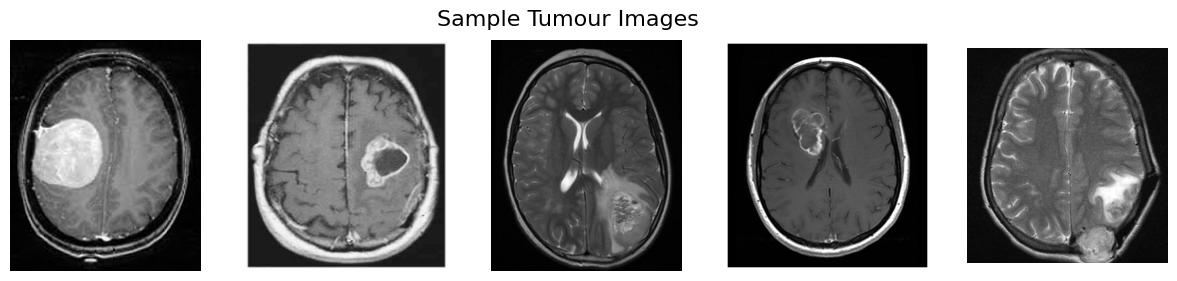

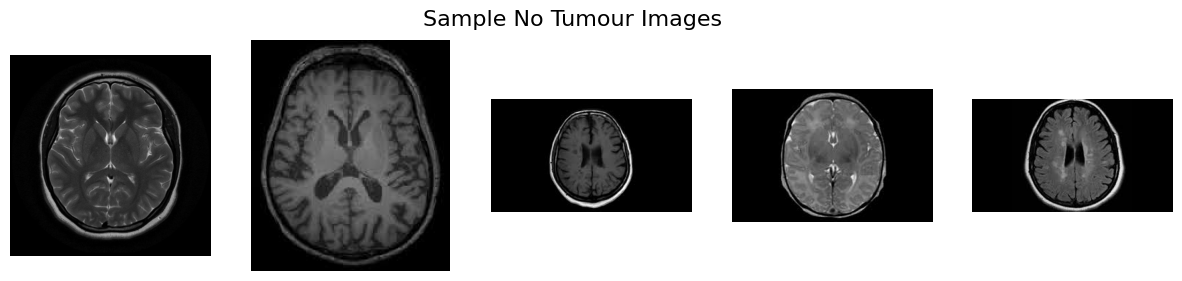

Tumour images: 155
No tumour images: 98


In [24]:
# Path to the MRI Images dataset
base_path = '../dataset/'
tumour_path = os.path.join(base_path, '../dataset/yes')
notumour_path = os.path.join(base_path, '../dataset/no')

# Display some sample images
def show_images(path, label, num_images=5):
    files = os.listdir(path)
    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Sample {label} Images', fontsize=16)
    for i in range(num_images):
        img_path = os.path.join(path, files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

show_images(tumour_path, 'Tumour')
show_images(notumour_path, 'No Tumour')

tumour_files = os.listdir(tumour_path)
notumour_files = os.listdir(notumour_path)
print(f"Tumour images: {len(tumour_files)}")
print(f"No tumour images: {len(notumour_files)}")

## Data PreProcessing

In [25]:
# Set up image data generators with augmentation
img_width, img_height = 150, 150

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


## Model Training and Comparison

### Model 1 : Custom CNN

In [26]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.summary()

history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 542ms/step - accuracy: 0.5673 - loss: 0.8220 - val_accuracy: 0.6875 - val_loss: 0.5770
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7188 - loss: 0.5829 - val_accuracy: 0.7188 - val_loss: 0.5747
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.7251 - loss: 0.5833 - val_accuracy: 0.8438 - val_loss: 0.4392
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7188 - loss: 0.5777 - val_accuracy: 0.7188 - val_loss: 0.6480
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 645ms/step - accuracy: 0.7895 - loss: 0.5531 - val_accuracy: 0.5938 - val_loss: 0.7039
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7500 - loss: 0.5832 - val_accuracy: 0.7188 - val_loss: 0.5725
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - accuracy: 0.7719 - loss: 0.4956 - val_accuracy: 0.8125 - val_loss: 0.5004
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7188 - loss: 0.6759 - val_accuracy: 0.6562 - val_loss: 0.6

### Model 2: VGG16 with Transfer Learning

In [27]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classifier on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs=base_model.input, outputs=predictions)

model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5556 - loss: 0.7303 - val_accuracy: 0.6562 - val_loss: 0.6033
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 618ms/step - accuracy: 0.5938 - loss: 0.6376 - val_accuracy: 0.6250 - val_loss: 0.6311
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6901 - loss: 0.5878 - val_accuracy: 0.7188 - val_loss: 0.5127
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 635ms/step - accuracy: 0.8438 - loss: 0.4118 - val_accuracy: 0.7812 - val_loss: 0.4866
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7485 - loss: 0.5141 - val_accuracy: 0.8750 - val_loss: 0.4052
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 553ms/step - accuracy: 0.6875 - loss: 0.5848 - val_accuracy: 0.7812 - val_loss: 0.4909
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7778 - loss: 0.4973 - val_accuracy: 0.8125 - val_loss: 0.4112
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.8438 - loss: 0.3562 - val_accuracy: 0.7500 - val_loss: 0.4397


## Model Performance and Evaluation


--- Custom CNN Evaluation ---


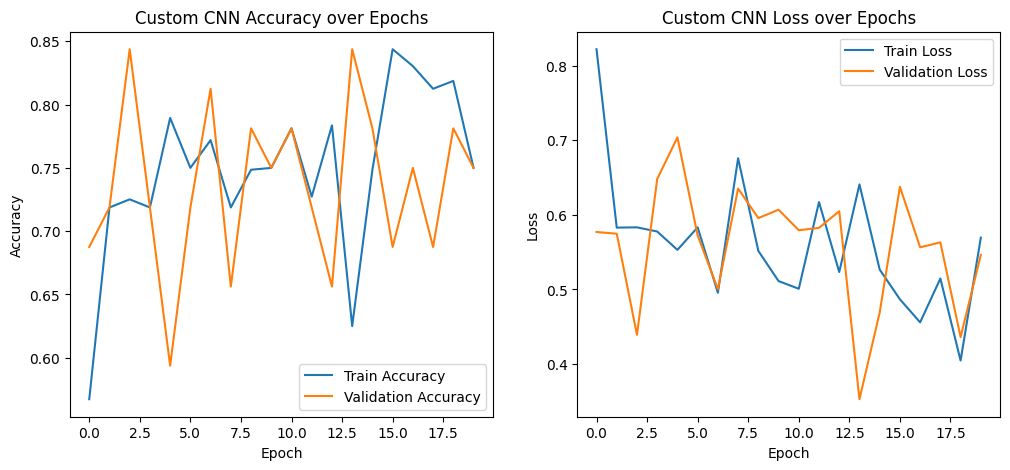

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step

Classification Report:
              precision    recall  f1-score   support

          no       0.90      0.58      0.71        98
         yes       0.78      0.96      0.86       155

    accuracy                           0.81       253
   macro avg       0.84      0.77      0.79       253
weighted avg       0.83      0.81      0.80       253


Confusion Matrix:


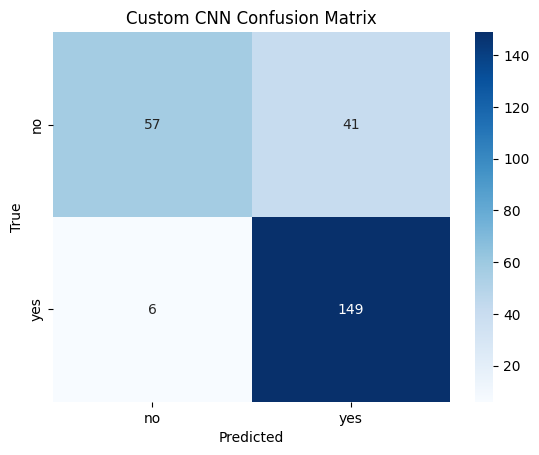


--- VGG16 Transfer Learning Evaluation ---


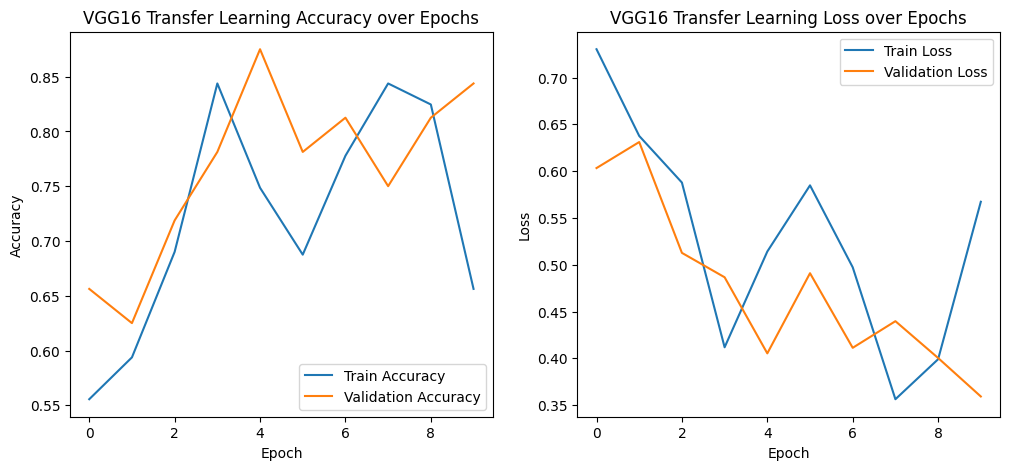

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step

Classification Report:
              precision    recall  f1-score   support

          no       0.88      0.78      0.83        98
         yes       0.87      0.94      0.90       155

    accuracy                           0.87       253
   macro avg       0.88      0.86      0.86       253
weighted avg       0.87      0.87      0.87       253


Confusion Matrix:


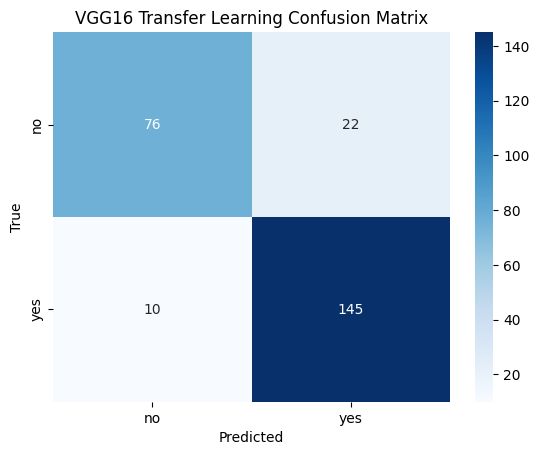

In [28]:
def evaluate_model(model, history, test_generator, title):
    print(f"\n--- {title} Evaluation ---")
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Get predictions and true labels from the test set
    y_pred = (model.predict(test_generator) > 0.5).astype("int32")
    y_true = test_generator.classes

    # Display classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['no', 'yes']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{title} Confusion Matrix')
    plt.show()

evaluate_model(model_1, history_1, test_generator, 'Custom CNN')
evaluate_model(model_2, history_2, test_generator, 'VGG16 Transfer Learning')

## Save the Best Model

In [29]:
# Compare the two models
best_model = None
if max(history_1.history['val_accuracy']) > max(history_2.history['val_accuracy']): 
    best_model = model_1
    print("Custom CNN is the best model.")
else:
    best_model = model_2
    print("VGG16 Transfer Learning is the best model.")

# Save the best model
best_model.save('../models/best_model_brain_tumor.keras')

print('Best model saved successfully.')

VGG16 Transfer Learning is the best model.
Best model saved successfully.
